In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(
    font_scale=2,
    style="whitegrid", 
    rc={'figure.figsize':(20,10)})

## 0 Context

This [Kaggle dataset](https://www.kaggle.com/mursideyarkin/mobile-games-ab-testing-cookie-cats) includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate30 or gate40.

Let's explore and preprocess data, carry out AB-test.

In [2]:
ab_cats = pd.read_csv('cookie_cats.csv')
ab_cats.head()

,userid,version,sum_game_rounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Content
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

* *userid* - A unique number that identifies each player.
* *version* - Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
* *sum_game_rounds* - the number of game rounds played by the player during the first 14 days after install.
* *retention1* - Did the player come back and play 1 day after installing?
* *retention_7* - Did the player come back and play 7 days after installing?

## 1 EDA

In [3]:
ab_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   userid           90189 non-null  int64 
 1   version          90189 non-null  object
 2   sum_game_rounds  90189 non-null  int64 
 3   retention_1      90189 non-null  bool  
 4   retention_7      90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [13]:
ab_cats[ab_cats.duplicated(keep=False)]

,userid,version,sum_game_rounds,retention_1,retention_7


### 1.1 Summary stats

In [4]:
# Target stats
ab_cats.describe()[['sum_game_rounds']].T

,count,mean,std,min,25%,50%,75%,max
sum_game_rounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


Summary stats by groups

In [5]:
# Control and Test Groups stats
ab_cats.groupby('version') \
       .agg({'sum_game_rounds': ['count', 'median', 'mean', 'std', 'min', 'max']})

sum_game_rounds                                         
                  count median       mean         std min    max
version                                                         
gate_30           44700     17  52.456264  256.716423   0  49854
gate_40           45489     16  51.298776  103.294416   0   2640

In [6]:
# With retention dimensions
ab_cats.groupby(['version', 'retention_1', 'retention_7']) \
       .agg({'sum_game_rounds': ['count', 'median', 'mean', 'std', 'min', 'max']})

sum_game_rounds                     \
                                          count median        mean   
version retention_1 retention_7                                      
gate_30 False       False                 22840      6   11.819746   
                    True                   1826     43  100.431544   
        True        False                 13358     33   49.694490   
                    True                   6676    127  183.886309   
gate_40 False       False                 23597      6   11.913294   
                    True                   1773     47   75.261139   
        True        False                 13613     32   50.025490   
                    True                   6506    133  190.282355   

                                                         
                                         std min    max  
version retention_1 retention_7                          
gate_30 False       False          21.642643   0    981  
                    True         1168.683901   0  49854  
        True        False          58.125396   0    918  
                    True          189.626390   0   2961  
gate_40 False       False          20.901020   0    547  
                    True           94.478048   0   1241  
        True        False          60.924587   0   2640  
                    True          194.220077   0   2294

In [8]:
# How many people reach the target in groups
ab_cats.groupby(['version', 'sum_game_rounds']) \
       .agg(user_counts=('userid', 'nunique')) \
       .loc[[('gate_30', 30), ('gate_40', 40)]]

,,user_counts
version,sum_game_rounds,
gate_30,30,298
gate_40,40,227


### 1.2 Visualization

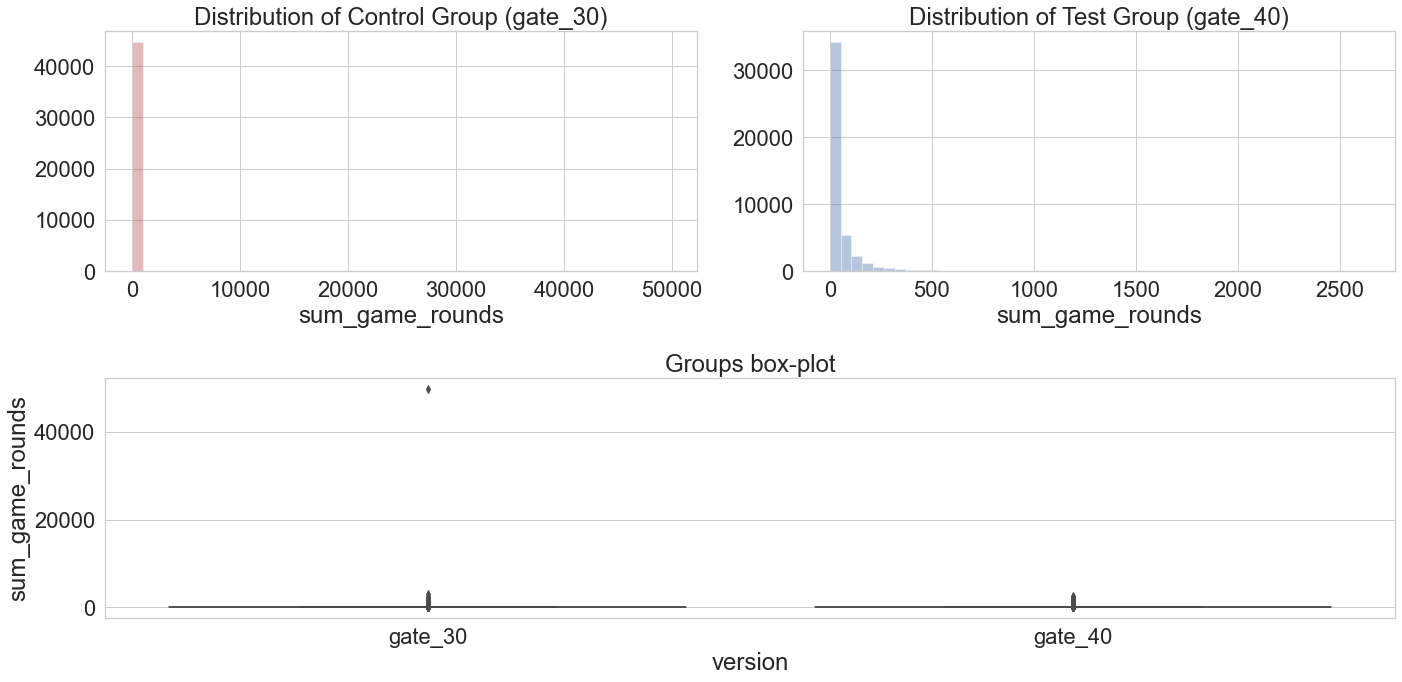

In [9]:
# First plot
ax1 = plt.subplot(221)
ax1.set_title('Distribution of Control Group (gate_30)')
sns.distplot(ab_cats.query('version == "gate_30"').sum_game_rounds, kde=False, color="r", ax=ax1)
#Second plot
ax2 = plt.subplot(222)
ax2.set_title('Distribution of Test Group (gate_40)')
sns.distplot(ab_cats.query('version == "gate_40"').sum_game_rounds, kde=False, color="b", ax=ax2)
# Third plot
ax3 = plt.subplot(212)
ax3.set_title('Groups box-plot')
sns.boxplot(x=ab_cats.version, y=ab_cats.sum_game_rounds, ax=ax3)
plt.tight_layout()

We've got outlier in control group, and people with no experience in the game. Let's drop it.

In [10]:
ab_cats = ab_cats.drop(index=ab_cats.sum_game_rounds.idxmax())
ab_cats = ab_cats.query('sum_game_rounds > 0').reset_index(drop=True)
ab_cats.head()

,userid,version,sum_game_rounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


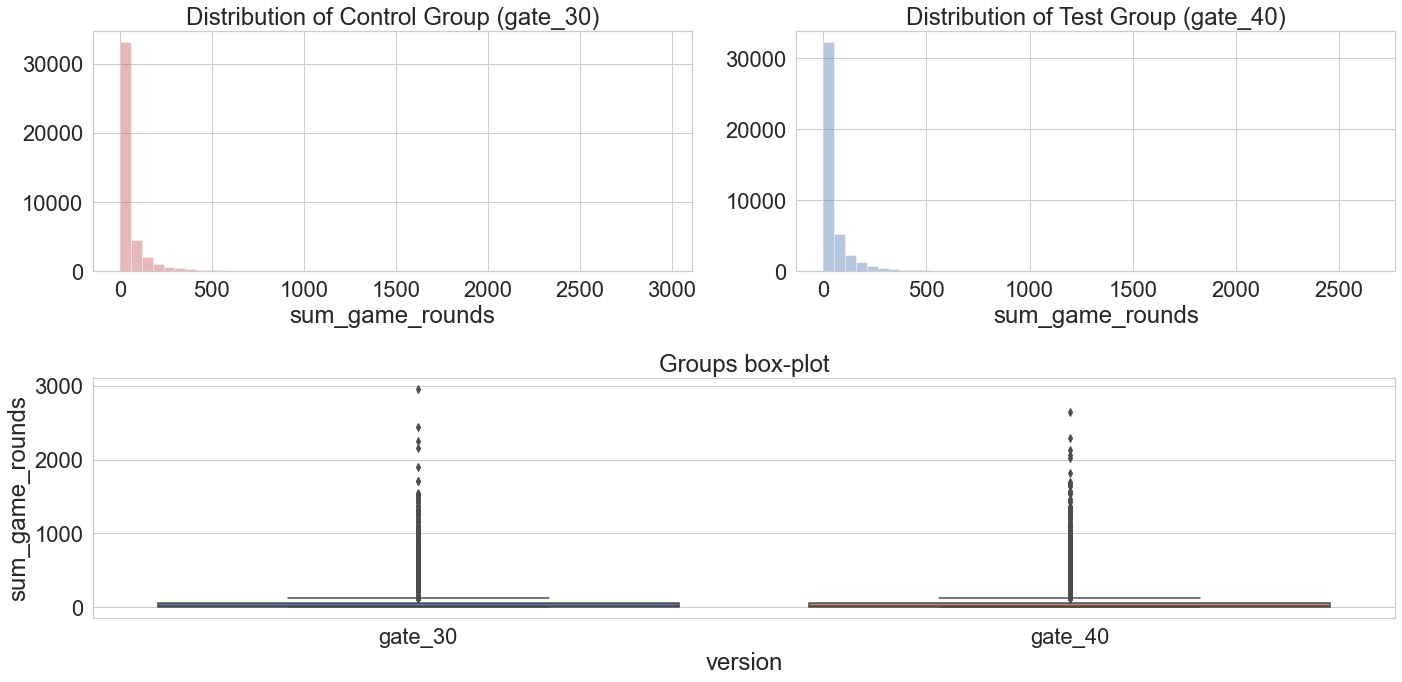

In [11]:
# First plot
ax1 = plt.subplot(221)
ax1.set_title('Distribution of Control Group (gate_30)')
sns.distplot(ab_cats.query('version == "gate_30"').sum_game_rounds, kde=False, color="r", ax=ax1)
#Second plot
ax2 = plt.subplot(222)
ax2.set_title('Distribution of Test Group (gate_40)')
sns.distplot(ab_cats.query('version == "gate_40"').sum_game_rounds, kde=False, color="b", ax=ax2)
# Third plot
ax3 = plt.subplot(212)
ax3.set_title('Groups box-plot')
sns.boxplot(x=ab_cats.version, y=ab_cats.sum_game_rounds, ax=ax3)
plt.tight_layout()